# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


## Project Steps

1. <a href="#eda">Data Exploration</a>
2. <a href="#cleaning">Cleaning</a>


<a id="#eda"></a>

# Data Exploration

In [1]:
import pandas as pd
import seaborn as sns
#import numpy as np
import math
#import json
%matplotlib inline

import utils

# read in the json files
offers = pd.read_json('data/portfolio.json', orient='records', lines=True)
users = pd.read_json('data/profile.json', orient='records', lines=True)
transactions = pd.read_json('data/transcript.json', orient='records', lines=True)

## offers

In [2]:
offers

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


This data set is pretty simple. There were 10 different offers:
- 4 BOGO
- 4 discounts
- informational

All offers were sent through **email**. Other channels were used for different offers.

## users

In [3]:
users.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [5]:
users.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


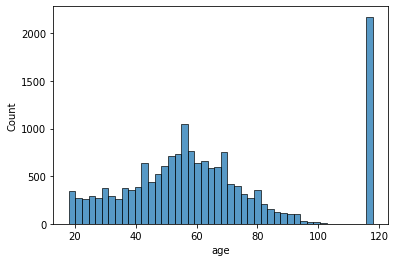

In [6]:
sns.histplot(data=users, x='age');

**users** data set has some missing values in **gender** and **income** columns. Missing values in **age** encoded as 118.

In [7]:
users['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

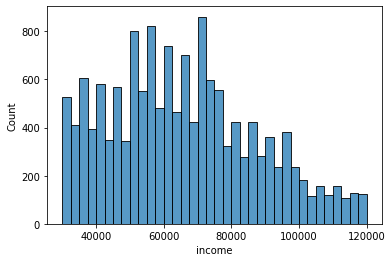

In [8]:
sns.histplot(data=users, x='income');

In [9]:
cnt_no_gender = len(users[users['gender'].isnull()])
cnt_no_income = len(users[users['income'].isnull()])
cnt_no_gender_income = len(users[users['gender'].isnull() & users['income'].isnull()])
print(f'no gender {cnt_no_gender}\nno income {cnt_no_income}\nno gender and income {cnt_no_gender_income}')

no gender 2175
no income 2175
no gender and income 2175


Users either have all data, or missing both **gender** and **income**.

## transactions

In [10]:
transactions.iloc[20000:20006,:]

,person,event,value,time
20000,158ccf2ed90541e7973106134cb1bba3,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,12
20001,4d81f9f887724401a9c7606db4afef01,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},12
20002,f2265b809d1949c1a7b63a9386bf4946,transaction,{'amount': 17.68},12
20003,f2265b809d1949c1a7b63a9386bf4946,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,12
20004,19afb26b9a10447a8a2f86fa9f65c75d,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},12
20005,94d82c681c994c319b4f3b648e351e56,transaction,{'amount': 6.33},12


In [11]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


There are no missing data.

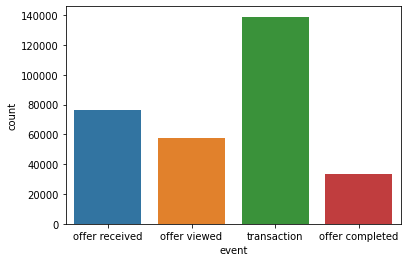

In [12]:
sns.countplot(x='event', data=transactions);

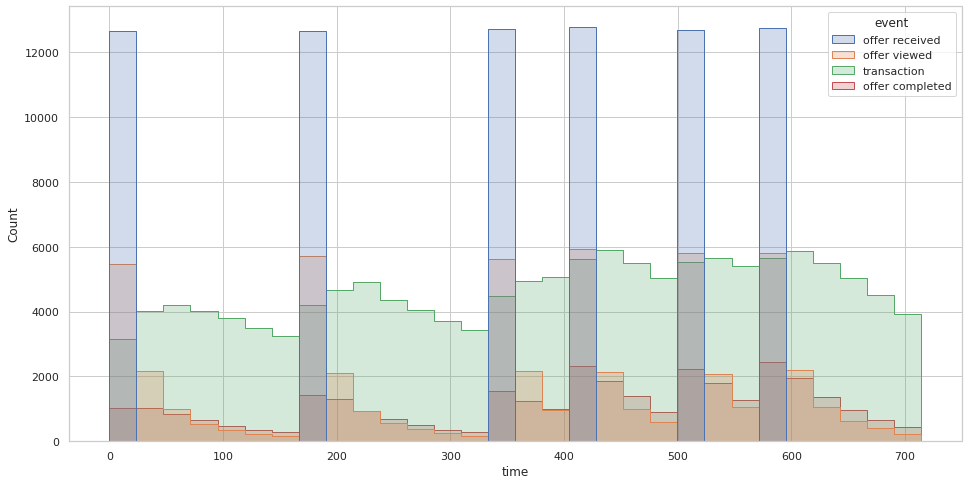

In [13]:
time_in_days = math.ceil(transactions['time'].max()/24)
sns.set(style="whitegrid", rc={'figure.figsize':(16,8)})
sns.histplot(x='time', data=transactions, hue='event', element="step", bins=time_in_days);
sns.reset_defaults()


## Combine datasets

<a id="#cleaning"></a>

## Cleaning

### offers

In [14]:
channels_list = set([val for sublist in offers['channels'] for val in sublist])
channels_list

{'email', 'mobile', 'social', 'web'}

In [15]:
for channel in channels_list:
    offers['offer_thru_'+channel] = offers['channels'].apply(lambda x: int(channel in x))
offers = offers.drop(columns='channels')
offers

,reward,difficulty,duration,offer_type,id,offer_thru_social,offer_thru_email,offer_thru_mobile,offer_thru_web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,0,1,1,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,1,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,0,1,1,1


In [16]:
offers = pd.concat([offers, pd.get_dummies(offers['offer_type'])], axis=1).drop(columns=['offer_type'])
offers

,reward,difficulty,duration,id,offer_thru_social,offer_thru_email,offer_thru_mobile,offer_thru_web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,1,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,0,1,1,1,0,1,0


### users

In [17]:
users['gender'] = users['gender'].fillna('no_gender')
users = pd.concat([users, pd.get_dummies(users['gender'])], axis=1).drop(columns='gender')
users

,age,id,became_member_on,income,F,M,O,no_gender
0,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,0,0,0,1
1,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,0,0,0
2,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,0,0,0,1
3,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1,0,0,0
4,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,0,0,0,1
...,...,...,...,...,...,...,...,...
16995,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,1,0,0,0
16996,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,0,1,0,0
16997,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,0,1,0,0
16998,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,1,0,0,0


### transactions

In [18]:
values_list = set([val for dict_vals in transactions['value'] for val in dict(dict_vals).keys()])
values_list

{'amount', 'offer id', 'offer_id', 'reward'}

There are 2 different spellings for **offer id**. We will need to combine them.

In [19]:
for val in values_list:
    transactions[val] = transactions['value'].apply(lambda x: val in dict(x).keys())
transactions

,person,event,value,time,offer id,reward,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,True,False,False,False
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,True,False,False,False
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,True,False,False,False
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,True,False,False,False
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,True,False,False,False
...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,False,False,True,False
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,False,False,True,False
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,False,False,True,False
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,False,False,True,False


In [20]:
transactions[transactions['offer_id'] & transactions['offer id']]

,person,event,value,time,offer id,reward,amount,offer_id


Just made sure that there are no records with both **offer_id** and  **offer id**.

In [21]:
new_value_columns = transactions.apply(lambda x: [
            x['value'].get('offer_id',0) if x['value'].get('offer_id',0) else x['value'].get('offer id',0),
            x['value'].get('amount',0),
            x['value'].get('reward',0)
        ], axis=1, result_type='expand')
new_transactions = pd.concat([transactions, new_value_columns], axis=1)
new_transactions.iloc[12735:12745,:]

,person,event,value,time,offer id,reward,amount,offer_id,0,1,2
12735,662f3247f37c4ae7a2abb8f6e266a633,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,True,False,False,False,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0
12736,a453d70e85fd493f9584570a3dae58a8,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,True,False,False,False,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0
12737,c3b7848d96014017ad1272188e170554,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,True,False,False,False,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00,0.0
12738,7ca349e55ff544c7a13addfdea2e2c06,transaction,{'amount': 1.02},0,False,False,True,False,0.0,1.02,0.0
12739,6ec36134940f43aeb43cffa2011a6d26,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,True,False,False,False,2298d6c36e964ae4a3e7e9706d1fb8c2,0.00,0.0
12740,461e13a14a074077b3ebd7ad0174e02b,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,True,False,False,False,fafdcd668e3743c1bb461111dcafc2a4,0.00,0.0
12741,490b282bfc3945df8ac3bbe54dd400fe,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,True,False,False,False,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0
12742,d72d201be5794279aa716d8ad82b8d90,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,True,False,False,False,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0
12743,d72d201be5794279aa716d8ad82b8d90,transaction,{'amount': 13.57},0,False,False,True,False,0.0,13.57,0.0
12744,d72d201be5794279aa716d8ad82b8d90,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,0,False,True,False,True,f19421c1d4aa40978ebb69ca19b0e20d,0.00,5.0


In [22]:
new_transactions = new_transactions.drop(columns=['value','amount','offer_id','reward','offer id'])
new_transactions = new_transactions.rename(columns={0:'offer',1:'amount',2:'reward_earned'})
new_transactions.iloc[12735:12745,:]

,person,event,time,offer,amount,reward_earned
12735,662f3247f37c4ae7a2abb8f6e266a633,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0
12736,a453d70e85fd493f9584570a3dae58a8,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0
12737,c3b7848d96014017ad1272188e170554,offer viewed,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00,0.0
12738,7ca349e55ff544c7a13addfdea2e2c06,transaction,0,0.0,1.02,0.0
12739,6ec36134940f43aeb43cffa2011a6d26,offer viewed,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0.00,0.0
12740,461e13a14a074077b3ebd7ad0174e02b,offer viewed,0,fafdcd668e3743c1bb461111dcafc2a4,0.00,0.0
12741,490b282bfc3945df8ac3bbe54dd400fe,offer viewed,0,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0
12742,d72d201be5794279aa716d8ad82b8d90,offer viewed,0,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0
12743,d72d201be5794279aa716d8ad82b8d90,transaction,0,0.0,13.57,0.0
12744,d72d201be5794279aa716d8ad82b8d90,offer completed,0,f19421c1d4aa40978ebb69ca19b0e20d,0.00,5.0


In [23]:
new_transactions.shape

(306534, 6)

##### Creating one record for each user-offer

In [24]:
new_transactions['time'] = new_transactions['time'] + 1
new_transactions

,person,event,time,offer,amount,reward_earned
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,1,2906b810c7d4411798c6938adc9daaa5,0.00,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,1,fafdcd668e3743c1bb461111dcafc2a4,0.00,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,1,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00,0.0
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,715,0.0,1.59,0.0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,715,0.0,9.53,0.0
306531,a00058cf10334a308c68e7631c529907,transaction,715,0.0,3.61,0.0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,715,0.0,3.53,0.0


In [25]:
event_received_df = new_transactions[new_transactions['event']=='offer received']
event_viewed_df = new_transactions[new_transactions['event']=='offer viewed']
event_transaction_df = new_transactions[new_transactions['event']=='transaction']
event_completed_df = new_transactions[new_transactions['event']=='offer completed']
print(event_received_df.shape)
print(event_viewed_df.shape)
print(event_transaction_df.shape)
print(event_completed_df.shape)
print(f'Total: {event_received_df.shape[0]+event_viewed_df.shape[0]+event_transaction_df.shape[0]+event_completed_df.shape[0]}')

(76277, 6)
(57725, 6)
(138953, 6)
(33579, 6)
Total: 306534


In [26]:
event_received_df[(event_received_df['amount']!=0) | (event_received_df['reward_earned']!=0)]

,person,event,time,offer,amount,reward_earned


In [27]:
event_received_df = event_received_df.rename(columns={'time':'offer_received'}).drop(columns=['event','amount','reward_earned'])
event_received_df

,person,offer_received,offer
0,78afa995795e4d85b5d9ceeca43f5fef,1,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,1,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,1,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,1,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,1,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...
257882,d087c473b4d247ccb0abfef59ba12b0e,577,ae264e3637204a6fb9bb56bc8210ddfd
257883,cb23b66c56f64b109d673d5e56574529,577,2906b810c7d4411798c6938adc9daaa5
257884,6d5f3a774f3d4714ab0c092238f3a1d7,577,2298d6c36e964ae4a3e7e9706d1fb8c2
257885,9dc1421481194dcd9400aec7c9ae6366,577,ae264e3637204a6fb9bb56bc8210ddfd


In [28]:
event_viewed_df[(event_viewed_df['amount']!=0) | (event_viewed_df['reward_earned']!=0)]

,person,event,time,offer,amount,reward_earned


In [29]:
event_viewed_df = event_viewed_df.rename(columns={'time':'offer_viewed'}).drop(columns=['event','amount','reward_earned'])
event_viewed_df

,person,offer_viewed,offer
12650,389bc3fa690240e798340f5a15918d5c,1,f19421c1d4aa40978ebb69ca19b0e20d
12651,d1ede868e29245ea91818a903fec04c6,1,5a8bc65990b245e5a138643cd4eb9837
12652,102e9454054946fda62242d2e176fdce,1,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,02c083884c7d45b39cc68e1314fec56c,1,ae264e3637204a6fb9bb56bc8210ddfd
12655,be8a5d1981a2458d90b255ddc7e0d174,1,5a8bc65990b245e5a138643cd4eb9837
...,...,...,...
306441,d56386cf344c4829bbf420d1895dca37,715,5a8bc65990b245e5a138643cd4eb9837
306450,9b51e8797290403b90d09d864dec4b94,715,3f207df678b143eea3cee63160fa8bed
306483,84fb57a7fe8045a8bf6236738ee73a0f,715,5a8bc65990b245e5a138643cd4eb9837
306490,abc4359eb34e4e2ca2349da2ddf771b6,715,3f207df678b143eea3cee63160fa8bed


In [30]:
event_received_df[event_received_df.duplicated(subset=['person','offer'], keep=False)].sort_values(by=['person','offer'])

,person,offer_received,offer
56475,00116118485d4dfda04fdbaba9a87b5c,169,f19421c1d4aa40978ebb69ca19b0e20d
248359,00116118485d4dfda04fdbaba9a87b5c,577,f19421c1d4aa40978ebb69ca19b0e20d
1889,0020c2b971eb4e9188eac86d93036a77,1,fafdcd668e3743c1bb461111dcafc2a4
112698,0020c2b971eb4e9188eac86d93036a77,337,fafdcd668e3743c1bb461111dcafc2a4
55857,003d66b6608740288d6cc97a6903f4f0,169,fafdcd668e3743c1bb461111dcafc2a4
...,...,...,...
184,fffad4f4828548d1b5583907f2e9906b,1,f19421c1d4aa40978ebb69ca19b0e20d
150794,fffad4f4828548d1b5583907f2e9906b,409,f19421c1d4aa40978ebb69ca19b0e20d
112214,ffff82501cea40309d5fdd7edcca4a07,337,2906b810c7d4411798c6938adc9daaa5
152030,ffff82501cea40309d5fdd7edcca4a07,409,2906b810c7d4411798c6938adc9daaa5


Users could receive the same offer a few times, sometimes, when previous didn't expire yet.

##### Merging received and viewed offers

In [31]:
event_received_viewed_df = pd.merge_asof(event_viewed_df, event_received_df, by=['person','offer'], left_on=['offer_viewed'], right_on=['offer_received'])
event_received_viewed_df['offer_viewed'] = event_received_viewed_df['offer_viewed'].astype(int)
event_received_viewed_df

,person,offer_viewed,offer,offer_received
0,389bc3fa690240e798340f5a15918d5c,1,f19421c1d4aa40978ebb69ca19b0e20d,1
1,d1ede868e29245ea91818a903fec04c6,1,5a8bc65990b245e5a138643cd4eb9837,1
2,102e9454054946fda62242d2e176fdce,1,4d5c57ea9a6940dd891ad53e9dbe8da0,1
3,02c083884c7d45b39cc68e1314fec56c,1,ae264e3637204a6fb9bb56bc8210ddfd,1
4,be8a5d1981a2458d90b255ddc7e0d174,1,5a8bc65990b245e5a138643cd4eb9837,1
...,...,...,...,...
57720,d56386cf344c4829bbf420d1895dca37,715,5a8bc65990b245e5a138643cd4eb9837,577
57721,9b51e8797290403b90d09d864dec4b94,715,3f207df678b143eea3cee63160fa8bed,577
57722,84fb57a7fe8045a8bf6236738ee73a0f,715,5a8bc65990b245e5a138643cd4eb9837,577
57723,abc4359eb34e4e2ca2349da2ddf771b6,715,3f207df678b143eea3cee63160fa8bed,577


In [32]:
event_received_viewed_df = event_received_df.merge(event_received_viewed_df, how='left', on=['person','offer','offer_received'])
event_received_viewed_df['offer_viewed'] = event_received_viewed_df['offer_viewed'].fillna(0).astype(int)
event_received_viewed_df

,person,offer_received,offer,offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,7
1,a03223e636434f42ac4c3df47e8bac43,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,7
2,e2127556f4f64592b11af22de27a7932,1,2906b810c7d4411798c6938adc9daaa5,19
3,8ec6ce2a7e7949b1bf142def7d0e0586,1,fafdcd668e3743c1bb461111dcafc2a4,13
4,68617ca6246f4fbc85e91a2a49552598,1,4d5c57ea9a6940dd891ad53e9dbe8da0,85
...,...,...,...,...
76272,d087c473b4d247ccb0abfef59ba12b0e,577,ae264e3637204a6fb9bb56bc8210ddfd,673
76273,cb23b66c56f64b109d673d5e56574529,577,2906b810c7d4411798c6938adc9daaa5,0
76274,6d5f3a774f3d4714ab0c092238f3a1d7,577,2298d6c36e964ae4a3e7e9706d1fb8c2,589
76275,9dc1421481194dcd9400aec7c9ae6366,577,ae264e3637204a6fb9bb56bc8210ddfd,625


In [33]:
offer_duration = dict(zip(offers['id'], offers['duration']*24))
offer_duration

{'ae264e3637204a6fb9bb56bc8210ddfd': 168,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 120,
 '3f207df678b143eea3cee63160fa8bed': 96,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 168,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 240,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 168,
 'fafdcd668e3743c1bb461111dcafc2a4': 240,
 '5a8bc65990b245e5a138643cd4eb9837': 72,
 'f19421c1d4aa40978ebb69ca19b0e20d': 120,
 '2906b810c7d4411798c6938adc9daaa5': 168}

In [34]:
event_received_viewed_df['offer_expire'] = event_received_viewed_df.apply(lambda x: x['offer_received']+offer_duration[x['offer']], axis=1)
event_received_viewed_df

,person,offer_received,offer,offer_viewed,offer_expire
0,78afa995795e4d85b5d9ceeca43f5fef,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,169
1,a03223e636434f42ac4c3df47e8bac43,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,7,241
2,e2127556f4f64592b11af22de27a7932,1,2906b810c7d4411798c6938adc9daaa5,19,169
3,8ec6ce2a7e7949b1bf142def7d0e0586,1,fafdcd668e3743c1bb461111dcafc2a4,13,241
4,68617ca6246f4fbc85e91a2a49552598,1,4d5c57ea9a6940dd891ad53e9dbe8da0,85,121
...,...,...,...,...,...
76272,d087c473b4d247ccb0abfef59ba12b0e,577,ae264e3637204a6fb9bb56bc8210ddfd,673,745
76273,cb23b66c56f64b109d673d5e56574529,577,2906b810c7d4411798c6938adc9daaa5,0,745
76274,6d5f3a774f3d4714ab0c092238f3a1d7,577,2298d6c36e964ae4a3e7e9706d1fb8c2,589,745
76275,9dc1421481194dcd9400aec7c9ae6366,577,ae264e3637204a6fb9bb56bc8210ddfd,625,745


##### Merge transactions with completed offers.

In [35]:
event_completed_df

,person,event,time,offer,amount,reward_earned
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,1,2906b810c7d4411798c6938adc9daaa5,0.0,2.0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,1,fafdcd668e3743c1bb461111dcafc2a4,0.0,2.0
12679,629fc02d56414d91bca360decdfa9288,offer completed,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,1,ae264e3637204a6fb9bb56bc8210ddfd,0.0,10.0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,1,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,10.0
...,...,...,...,...,...,...
306475,0c027f5f34dd4b9eba0a25785c611273,offer completed,715,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,3.0
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,715,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,3.0
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,715,fafdcd668e3743c1bb461111dcafc2a4,0.0,2.0
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,715,fafdcd668e3743c1bb461111dcafc2a4,0.0,2.0


In [36]:
event_completed_df[event_completed_df['amount']!=0]

,person,event,time,offer,amount,reward_earned


In [37]:
event_completed_df = event_completed_df.rename(columns={'time':'offer_completed'}).drop(columns=['event','amount'])
event_completed_df

,person,offer_completed,offer,reward_earned
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,1,2906b810c7d4411798c6938adc9daaa5,2.0
12672,fe97aa22dd3e48c8b143116a8403dd52,1,fafdcd668e3743c1bb461111dcafc2a4,2.0
12679,629fc02d56414d91bca360decdfa9288,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
12692,676506bad68e4161b9bbaffeb039626b,1,ae264e3637204a6fb9bb56bc8210ddfd,10.0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,1,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0
...,...,...,...,...
306475,0c027f5f34dd4b9eba0a25785c611273,715,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0
306497,a6f84f4e976f44508c358cc9aba6d2b3,715,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0
306506,b895c57e8cd047a8872ce02aa54759d6,715,fafdcd668e3743c1bb461111dcafc2a4,2.0
306509,8431c16f8e1d440880db371a68f82dd0,715,fafdcd668e3743c1bb461111dcafc2a4,2.0


In [38]:
event_transaction_df

,person,event,time,offer,amount,reward_earned
12654,02c083884c7d45b39cc68e1314fec56c,transaction,1,0.0,0.83,0.0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,1,0.0,34.56,0.0
12659,54890f68699049c2a04d415abc25e717,transaction,1,0.0,13.23,0.0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,1,0.0,19.51,0.0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,1,0.0,18.97,0.0
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,715,0.0,1.59,0.0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,715,0.0,9.53,0.0
306531,a00058cf10334a308c68e7631c529907,transaction,715,0.0,3.61,0.0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,715,0.0,3.53,0.0


In [39]:
event_transaction_df[(event_transaction_df['offer']!=0) | (event_transaction_df['reward_earned']!=0)]

,person,event,time,offer,amount,reward_earned


**offer** and **reward_earned**  are always equal to 0, and **offer** is always equal to 'transaction', so we can drop these columns.

In [40]:
event_transaction_df = event_transaction_df.rename(columns={'time':'transaction'}).drop(columns=['event','offer','reward_earned'])
event_transaction_df

,person,transaction,amount
12654,02c083884c7d45b39cc68e1314fec56c,1,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,1,34.56
12659,54890f68699049c2a04d415abc25e717,1,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,1,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,1,18.97
...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,715,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,715,9.53
306531,a00058cf10334a308c68e7631c529907,715,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,715,3.53


In [41]:
event_transaction_df.sort_values(by=['person','transaction']).head(10)

,person,transaction,amount
89291,0009655768c64bdeb2e877511632db8f,229,22.16
168412,0009655768c64bdeb2e877511632db8f,415,8.57
228422,0009655768c64bdeb2e877511632db8f,529,14.11
237784,0009655768c64bdeb2e877511632db8f,553,13.56
258883,0009655768c64bdeb2e877511632db8f,577,10.27
293497,0009655768c64bdeb2e877511632db8f,661,12.36
300930,0009655768c64bdeb2e877511632db8f,691,28.16
302205,0009655768c64bdeb2e877511632db8f,697,18.41
104088,00116118485d4dfda04fdbaba9a87b5c,295,0.70
187632,00116118485d4dfda04fdbaba9a87b5c,457,0.20


In [42]:
event_completed_df.sort_values(by=['person','offer_completed']).head(10)

,person,offer_completed,offer,reward_earned
168413,0009655768c64bdeb2e877511632db8f,415,f19421c1d4aa40978ebb69ca19b0e20d,5.0
228423,0009655768c64bdeb2e877511632db8f,529,fafdcd668e3743c1bb461111dcafc2a4,2.0
258884,0009655768c64bdeb2e877511632db8f,577,2906b810c7d4411798c6938adc9daaa5,2.0
95422,0011e0d4e6b944f998e987f904e8c1e5,253,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0
258980,0011e0d4e6b944f998e987f904e8c1e5,577,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0
258981,0011e0d4e6b944f998e987f904e8c1e5,577,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
31327,0020c2b971eb4e9188eac86d93036a77,55,fafdcd668e3743c1bb461111dcafc2a4,2.0
218936,0020c2b971eb4e9188eac86d93036a77,511,fafdcd668e3743c1bb461111dcafc2a4,2.0
218937,0020c2b971eb4e9188eac86d93036a77,511,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0
88010,0020ccbbb6d84e358d3414a3ff76cffd,223,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0


In [43]:
event_transaction_completed_df = pd.merge_asof(event_completed_df, event_transaction_df, by=['person'], left_on=['offer_completed'], right_on=['transaction'])
#event_transaction_completed_df['offer_viewed'] = event_received_viewed_df['offer_viewed'].astype(int)
event_transaction_completed_df.sort_values(by=['person','offer_completed']).head(10)

,person,offer_completed,offer,reward_earned,transaction,amount
14758,0009655768c64bdeb2e877511632db8f,415,f19421c1d4aa40978ebb69ca19b0e20d,5.0,415,8.57
22811,0009655768c64bdeb2e877511632db8f,529,fafdcd668e3743c1bb461111dcafc2a4,2.0,529,14.11
25942,0009655768c64bdeb2e877511632db8f,577,2906b810c7d4411798c6938adc9daaa5,2.0,577,10.27
8737,0011e0d4e6b944f998e987f904e8c1e5,253,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,253,11.93
25955,0011e0d4e6b944f998e987f904e8c1e5,577,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,577,22.05
25956,0011e0d4e6b944f998e987f904e8c1e5,577,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,577,22.05
2304,0020c2b971eb4e9188eac86d93036a77,55,fafdcd668e3743c1bb461111dcafc2a4,2.0,55,17.63
21175,0020c2b971eb4e9188eac86d93036a77,511,fafdcd668e3743c1bb461111dcafc2a4,2.0,511,17.24
21176,0020c2b971eb4e9188eac86d93036a77,511,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,511,17.24
7787,0020ccbbb6d84e358d3414a3ff76cffd,223,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,223,11.65


In [44]:
event_transaction_completed_df[event_transaction_completed_df['offer_completed']!=event_transaction_completed_df['transaction']]

,person,offer_completed,offer,reward_earned,transaction,amount


In [45]:
event_transaction_completed_df = event_transaction_df.merge(event_transaction_completed_df, how='left', on=['person','transaction','amount'])
event_transaction_completed_df['offer_completed'] = event_transaction_completed_df['offer_completed'].fillna(0).astype(int)
event_transaction_completed_df[['offer','reward_earned']] = event_transaction_completed_df[['offer','reward_earned']].fillna(0)
event_transaction_completed_df

,person,transaction,amount,offer_completed,offer,reward_earned
0,02c083884c7d45b39cc68e1314fec56c,1,0.83,0,0,0.0
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,1,34.56,1,2906b810c7d4411798c6938adc9daaa5,2.0
2,54890f68699049c2a04d415abc25e717,1,13.23,0,0,0.0
3,b2f1cd155b864803ad8334cdf13c4bd2,1,19.51,0,0,0.0
4,fe97aa22dd3e48c8b143116a8403dd52,1,18.97,1,fafdcd668e3743c1bb461111dcafc2a4,2.0
...,...,...,...,...,...,...
141910,b3a1272bc9904337b331bf348c3e8c17,715,1.59,0,0,0.0
141911,68213b08d99a4ae1b0dcb72aebd9aa35,715,9.53,0,0,0.0
141912,a00058cf10334a308c68e7631c529907,715,3.61,0,0,0.0
141913,76ddbd6576844afe811f1a3c0fbb5bec,715,3.53,0,0,0.0


More records, because of duplicates in completed offers:

| person | transaction | amount |offer_completed | offer |reward_earned |
| --- | - | - | - | - | - |
| 0011e0d4e6b944f998e987f904e8c1e5 | 253 | 11.93 | 253.0 | 2298d6c36e964ae4a3e7e9706d1fb8c2 | 3.0 |
| 0011e0d4e6b944f998e987f904e8c1e5 | 577 | 22.05 | 577.0 | 0b1e1539f2cc45b7b9fa7c272da2e1d7 | 5.0 |
| 0011e0d4e6b944f998e987f904e8c1e5 | 577 | 22.05 | 577.0 | 9b98b8c7a33c4b65b9aebfe6a799e6d9 | 5.0 |
| 0011e0d4e6b944f998e987f904e8c1e5 | 643 | 23.03 | NaN | NaN | NaN |


Some users received the same offer again, while previous didn't expire yet. If the time of completing is within the ranges of both offers, then there are going to be 2 the same records of completing the offer. So both offers will be considered as completed.

Received/Viewed:

| person | offer_received | offer |offer_viewed | offer_expire |
| --- | - | - | - | - |
| 1abeb816d9fa49b4b5b5ae51bc3d24c3 | 1 | fafdcd668e3743c1bb461111dcafc2a4 | 97 | 241 |
| 1abeb816d9fa49b4b5b5ae51bc3d24c3 | 169 | fafdcd668e3743c1bb461111dcafc2a4 | 181 | 409 |


Completed:

| person | offer_completed | offer |reward_earned |
| --- | - | - | - | 
| 1abeb816d9fa49b4b5b5ae51bc3d24c3 | 199 | fafdcd668e3743c1bb461111dcafc2a4 | 2.0 |
| 1abeb816d9fa49b4b5b5ae51bc3d24c3 | 199 | fafdcd668e3743c1bb461111dcafc2a4 | 2.0 |
| 1abeb816d9fa49b4b5b5ae51bc3d24c3 | 343 | 9b98b8c7a33c4b65b9aebfe6a799e6d9 | 5.0 |


After merging we get:

| person | offer_completed | offer |reward_earned | offer_received |offer_viewed | offer_expire |
| --- | - | - | - | - | - | - |
| 1abeb816d9fa49b4b5b5ae51bc3d24c3 | 199 | fafdcd668e3743c1bb461111dcafc2a4 | 2.0 | 169 | 181 | 409 |
| 1abeb816d9fa49b4b5b5ae51bc3d24c3 | 199 | fafdcd668e3743c1bb461111dcafc2a4 | 2.0 | 169 | 181 | 409 |
| 1abeb816d9fa49b4b5b5ae51bc3d24c3 | 343 | 9b98b8c7a33c4b65b9aebfe6a799e6d9 | 5.0 | 337 | 349 | 505 |


A user can receive an offer, never actually view the offer, and still complete the offer. So in this case the customer was not influenced by the offer.  
Let's find such users and remove transactions for "offer received" and "offer completed".

In [65]:
new_transactions[
    (new_transactions.duplicated(subset=['person','offer'],keep=False)) & 
    (new_transactions['offer']!=0)
].sort_values(by=['person','time','offer'])

,person,event,time,offer,amount,reward_earned
55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0
113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,0.0,0.0
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,0.0,0.0
153401,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0.0
...,...,...,...,...,...,...
214717,ffff82501cea40309d5fdd7edcca4a07,offer completed,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0
230690,ffff82501cea40309d5fdd7edcca4a07,offer viewed,534,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
246495,ffff82501cea40309d5fdd7edcca4a07,offer received,576,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
258362,ffff82501cea40309d5fdd7edcca4a07,offer completed,576,2906b810c7d4411798c6938adc9daaa5,0.0,2.0


In [70]:
new_transactions[
    (new_transactions.duplicated(subset=['person','offer'],keep=False)) & 
    (new_transactions['offer']!=0)
].sort_values(by=['person','time','offer']).groupby(['person','offer'])['event'].unique().reset_index()

,person,offer,event
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,"[offer received, offer completed]"
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]"
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,"[offer received, offer viewed]"
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,"[offer received, offer completed, offer viewed]"
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,"[offer received, offer completed, offer viewed]"
...,...,...,...
54743,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,"[offer received, offer viewed, offer completed]"
54744,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[offer received, offer viewed, offer completed]"
54745,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,"[offer received, offer viewed, offer completed]"
54746,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[offer received, offer completed, offer viewed]"


In [73]:
grouped_transactions = new_transactions[new_transactions['offer']!=0].groupby(['person','offer'])['event'].unique().reset_index()
grouped_transactions

,person,offer,event
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,"[offer received, offer completed]"
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]"
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,"[offer received, offer viewed]"
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,"[offer received, offer completed, offer viewed]"
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,"[offer received, offer completed, offer viewed]"
...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,"[offer received, offer viewed, offer completed]"
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[offer received, offer viewed, offer completed]"
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,"[offer received, offer viewed, offer completed]"
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[offer received, offer completed, offer viewed]"


In [76]:
not_viewed = grouped_transactions[grouped_transactions['event'].apply(lambda x: 'offer viewed' not in x)]
not_viewed

,person,offer,event
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,"[offer received, offer completed]"
13,0020c2b971eb4e9188eac86d93036a77,ae264e3637204a6fb9bb56bc8210ddfd,[offer received]
19,003d66b6608740288d6cc97a6903f4f0,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[offer received, offer completed]"
23,00426fe3ffde4c6b9cb9ad6d077a13ea,0b1e1539f2cc45b7b9fa7c272da2e1d7,[offer received]
24,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,[offer received]
...,...,...,...
63248,ffe5257abf8840b395e1ee6b29894637,5a8bc65990b245e5a138643cd4eb9837,[offer received]
63260,ffede3b700ac41d6a266fa1ba74b4f16,0b1e1539f2cc45b7b9fa7c272da2e1d7,[offer received]
63270,fff3ba4757bd42088c044ca26d73817a,2906b810c7d4411798c6938adc9daaa5,"[offer received, offer completed]"
63275,fff7576017104bcc8677a8d63322b5e1,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[offer received, offer completed]"


If an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

In [64]:
# informational offers, marked as compleated or with reward earned
new_transactions[
    (new_transactions['offer'].isin(
        ['3f207df678b143eea3cee63160fa8bed','5a8bc65990b245e5a138643cd4eb9837'])) & 
    ((new_transactions['event']=='offer completed') | (new_transactions['reward_earned']!=0))
]

,person,event,time,offer,amount,reward_earned


There are no informational offers, marked as completed or with reward earned.